In [1]:
# ---- Nested function ---- #
import os
import pandas as pd
import wfdb
import ast
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import gc
from pprint import pprint
from collections import Counter
import math
from copy import deepcopy
import random

# # ---- BWR ---- #
# import bwr
# import emd
import pywt
# ---- Scipy ---- #
from scipy import signal
from scipy.signal import butter, lfilter, freqz, filtfilt
from scipy.fftpack import fft
from scipy.signal import find_peaks
from scipy.interpolate import interp1d


# ---- PyTorch ---- #
import torch
import torchvision
import torch.nn.functional as Func
from torch import nn
from torch import optim
from torch import functional as F
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torchvision.transforms import ToTensor
from torch.nn.functional import softmax
from torch.nn.parallel import DistributedDataParallel
from pytorchtools import EarlyStopping
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce
import torchvision.ops as ops
import tensorboard
from tensorboardX import SummaryWriter
from torch.optim.lr_scheduler import ReduceLROnPlateau,CosineAnnealingLR,CosineAnnealingWarmRestarts

# ---- Scikit Learn ---- #
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.model_selection import KFold


# ---- Matplotlib ---- #
import matplotlib.pyplot as plt
import seaborn as sns

# ---- Summary ---- #
import pytorch_model_summary


In [2]:
def load_raw_data(df, sampling_rate, path):
    data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data

def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

In [3]:
sampling_rate = 500

ptb_xl_path = "/data/graduate/ptbxl_103/"

In [4]:
super_class = {}

classes_csv = pd.read_csv(ptb_xl_path+"scp_statements.csv")
classes_csv.rename(columns={"Unnamed: 0":"specific_class"}, inplace=True)
classes_csv["diagnostic_class"] = classes_csv["diagnostic_class"].fillna("OTHERS")

for i in range(len(classes_csv)):
    name = classes_csv.iloc[i].specific_class
    super_c = classes_csv.iloc[i].diagnostic_class
    super_class[name] = super_c

In [5]:
Y = pd.read_csv(ptb_xl_path+"ptbxl_database.csv", index_col="ecg_id")

In [6]:
class PTBXL(Dataset):
    
    def __init__(self, data_root, 
                folds=[1,2,3,4,5,6,7,8,9,10], 
                class_map = {"NORM":0, "MI":1, "STTC":2, "CD":3, "HYP":4},
                sampling_rate = 500,
                verbose=False,
                transform=None
                ):
        
            self.data_root = data_root
            y = pd.read_csv(os.path.join(self.data_root, 'ptbxl_database.csv'), index_col='ecg_id')
            self.folds = folds
            self.class_map = class_map
            self.sampling_rate = sampling_rate
            self.verbose = verbose
            self.transform = transform

            y = y.loc[y.strat_fold.isin(self.folds)]

             # Load scp_statements.csv for diagnostic aggregation
            agg_df = pd.read_csv(os.path.join(data_root, "scp_statements.csv"), index_col=0)
            self.agg_df = agg_df[agg_df.diagnostic == 1]

            # Apply diagnostic superclass
            y.scp_codes = y.scp_codes.apply(lambda x: ast.literal_eval(x))
            y['diagnostic_superclass'] = y.scp_codes.apply(self.aggregate_diagnostic)

            # Convert to Class numbers
            y["class_ids"] = y.diagnostic_superclass.apply(self.map_class_num)

            self.y = y

            if self.verbose:
                print("unique super classes=", self.agg_df.diagnostic_class.unique())
                print("unique folds=",self.y.strat_fold.unique())
                print(self.agg_df)
                print(self.y.scp_codes)
                print("Class labels=", self.y.diagnostic_superclass)
                print("Class ids=", self.y.class_ids)

    def aggregate_diagnostic(self, y_dic):
        tmp = []
        #print(y_dic)
        for key in y_dic.keys():
            if key in self.agg_df.index:
                tmp.append(self.agg_df.loc[key].diagnostic_class)
        #print("temp =",  tmp)
        return list(set(tmp))

    def map_class_num(self, class_labels):
        temp = []
        try:
            for l in class_labels:
                class_id = self.class_map[l]
                temp.append(class_id)
        except:
            print("These labels are wrong:", class_labels)
        return temp

    def read_row_data(self, data_path):
        signal, meta = wfdb.rdsamp(data_path)
        #data = np.array([signal for signal, meta in data])
        if self.verbose:
            print(signal)
            print(meta)
        return np.array(signal), meta
    
    # Powerline Noise Filtering
    def lowpass_filt(self, fs, low, order=5):
        nyq = 0.5 * fs # 250Hz
    #     lowcut = ((2*low)/fs)
        lowcut = low / nyq
        b, a = butter(order, lowcut, btype="low")
        return b, a
        
    def highpass_filt(self, fs, high, order=5):
        nyq = 0.5 * fs # 250Hz
    #     lowcut = ((2*low)/fs)
        highcut = high / nyq
        b, a = butter(order, highcut, btype="high")
        return b, a

    def powerline_Noise_Filtering(self, fs, low, order, data):
        b, a = self.lowpass_filt(fs, low, order)
        filtered_ecg_data = lfilter(b, a, data)
        return filtered_ecg_data

    def bandpass_filt(self, fs, low, high, order=5):
        nyq = 0.5 * fs
        lowcut = low / nyq
        highcut = high / nyq
        b, a = butter(order, [lowcut, highcut], btype="band")
        return b, a
    
    def butter_bandpass(self, fs, low, high ,data , order=5):
        b, a = self.bandpass_filt(fs, low, high, order)
        y = lfilter(b, a, data)
        return y
    
    def wavelet_baseline(self, x):
        level = 8
        wavelet = "sym4"
        coeffs = pywt.wavedec(x, wavelet, level=level)
        threshold=1.2
        coeffs[1:] = (pywt.threshold(c, threshold, mode='soft') for c in coeffs[1:])
        signal = pywt.waverec(coeffs,wavelet)
        return x-signal

    
    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):

        y_row = self.y.iloc[idx]
        class_ids = y_row.class_ids

        class_encoded = np.zeros(len(self.class_map))
        class_encoded[class_ids] = 1

        if self.verbose:
            print(class_ids)
            print(class_encoded)

        # To get sample rate 100 ECGs
        if self.sampling_rate == 100:
            data_path = os.path.join(self.data_root, y_row.filename_lr)
            ecg, meta = self.read_row_data(data_path)
        # To get sample rate 500 ECGs
        elif self.sampling_rate == 500:
            data_path = os.path.join(self.data_root, y_row.filename_hr)
            ecg, meta = self.read_row_data(data_path)

        else:
            print("Wrong sample rate")
            exit

        # Get transpose
        #print(ecg.shape)
        ecg = ecg.transpose()
        #print(ecg.shape)
#         ecg = torch.from_numpy(ecg).to(torch.float32)
#         class_encoded = torch.from_numpy(class_encoded).to(torch.float32)

        for lead in range(len(ecg)):
        #     #Powerline Noise Filtering
            ecg[lead] = self.powerline_Noise_Filtering(sampling_rate, 45, 5, ecg[lead])
            baseline = signal.medfilt(signal.medfilt(ecg[lead], int(0.3 * 500) - 1) , int(0.7* 500) - 1)
        #     ecg[lead] = ecg[lead]-baseline
            # ecg[lead] = self.wavelet_baseline(ecg[lead])
#         print("ecg_shape=", ecg.shape)
        sample = {"ecg":ecg, "class":class_encoded }
        return sample


In [7]:
train_data = PTBXL(ptb_xl_path,folds=[1,2,3,4,5,6,7,8,9],verbose=False)
# valid_data = PTBXL(ptb_xl_path,folds=[9],verbose=False)
test_data = PTBXL(ptb_xl_path,folds=[10],verbose=False)

In [8]:
x_train = []
y_train = []
# x_valid = []
# y_valid = []
x_test = []
y_test = []
# for i, d in enumerate(train_data):
#     ecg = d["ecg"]
#     labels = d["class"]
#     x_train.append(ecg)
#     y_train.append(labels)

# for i, d in enumerate(valid_data):
#     ecg = d["ecg"]
#     labels = d["class"]
#     x_valid.append(ecg)
#     y_valid.append(labels)
for i, d in enumerate(test_data):
    ecg = d["ecg"]
    labels = d["class"]
    if sum(labels) == 0:
        continue
    x_test.append(ecg)
    y_test.append(labels)

[0. 1. 0. 0. 0.]
[[-0.19  -0.19  -0.19  ...  0.02   0.02   0.02 ]
 [-0.175 -0.175 -0.175 ... -0.34  -0.34  -0.34 ]
 [ 0.015  0.015  0.015 ... -0.36  -0.36  -0.36 ]
 ...
 [ 0.04   0.04   0.04  ...  0.025  0.025  0.025]
 [ 0.02   0.02   0.02  ...  0.045  0.045  0.045]
 [ 0.025  0.025  0.025 ...  0.03   0.03   0.03 ]]


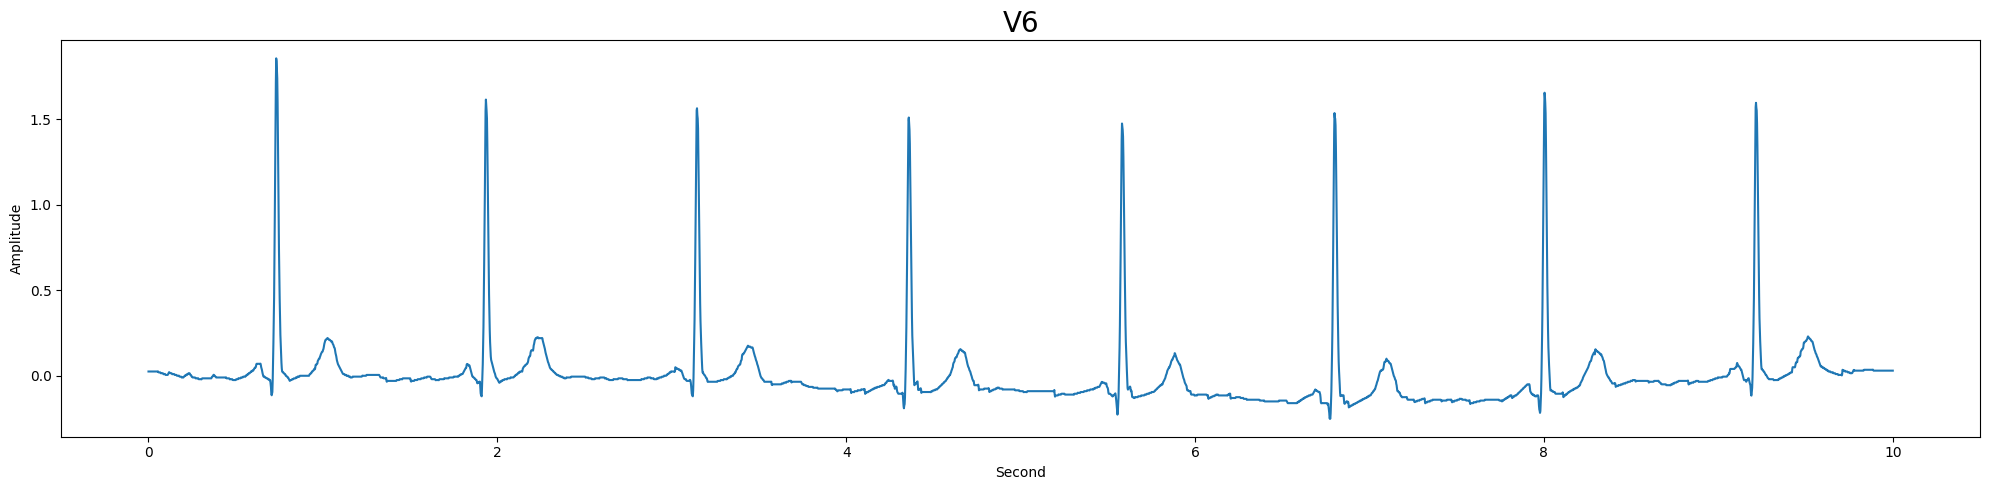

In [9]:
import ecg_plot
classes = ['NORM', 'MI', 'STTC', 'CD', 'HYP']
record_header = wfdb.rdheader(ptb_xl_path+"records500/00000/00001_hr")
leadNames = record_header.__dict__["sig_name"]
se = 34
ecg_data = x_test[se]
print(y_test[se])
fig = plt.figure(figsize=(20,5))
print(ecg_data)
for i,lead in enumerate(leadNames):
    ax1 = fig.add_subplot(3,4,i+1)
    ax1.set_title(leadNames[i], fontsize=20)
    ax1.plot(ecg_data[i])
# baseline = signal.medfilt(signal.medfilt(ecg_data[11][0:5000], int(0.3 * 500) - 1) , int(0.7* 500) - 1)
ax1 = fig.add_subplot(1,1,1)
ax1.set_title(leadNames[11], fontsize=20)
ax1.set_ylabel("Amplitude")
ax1.set_xlabel("Second")
ax1.plot(np.linspace(0,10,5000),ecg_data[11][0:5000])
fig.tight_layout()
# fig.savefig("./attention_result/Data_wavelet_Bf.png")

[1. 0. 0. 0. 0.]


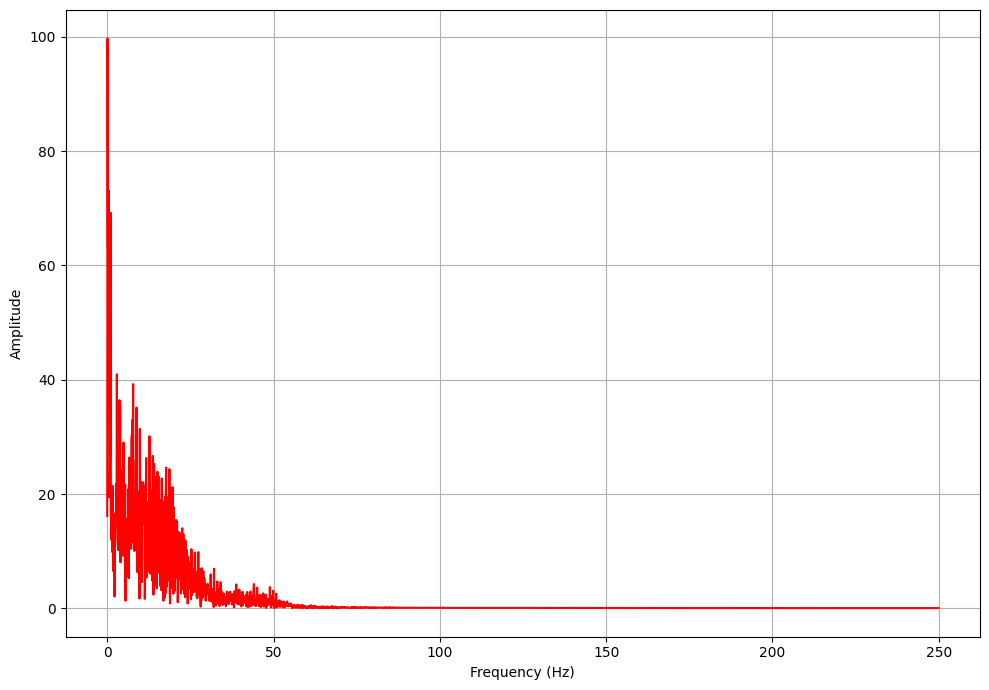

In [156]:
# 주파수 변환 (푸리에 변환)
se = 13
ecg_data = x_train[se][0]
print(y_test[se])
fs = 500
fft_result = fft(ecg_data)
freqs = np.fft.fftfreq(len(fft_result), 1/fs)

# 주파수 스펙트럼 시각화
fig = plt.figure(figsize=(10,7))

# for i,lead in enumerate(leadNames):
#     ax1 = fig.add_subplot(3,4,i+1)
#     ax1.set_title(leadNames[i], fontsize=20)
#     ax1.plot(ecg_data[i])
ax1 = fig.add_subplot(1,1,1)
# ax1.set_title('Frequency Spectrum of ECG Data, Lead1')
ax1.set_xlabel('Frequency (Hz)')
ax1.set_ylabel("Amplitude")
ax1.plot(freqs[:len(freqs)//2], np.abs(fft_result)[:len(fft_result)//2], "r")
ax1.grid(True)
fig.tight_layout()
fig.show()
fig.savefig("./attention_result/freq_af.png", dpi=100)
# plt.figure(figsize=(10, 6))
# plt.plot(freqs[:len(freqs)//2], np.abs(fft_result)[:len(fft_result)//2])
# plt.title('Frequency Spectrum of ECG Data, Lead1')
# plt.xlabel('Frequency (Hz)')
# plt.ylabel('Amplitude')
# plt.grid(True)
# plt.show()
# plt.savefig("./attention_result/freq_after.png", dpi=300)

# Fit Transform
# lead_Scaler = [StandardScaler() for _ in range(12)]
# stdScaler = StandardScaler() 
stdScaler= MinMaxScaler()
for i, xt in enumerate(x_train):
    r_xt = xt.T
    r_xt = stdScaler.fit_transform(r_xt)
    # r_xt = lead_Scaler[j].fit_transform(r_xt)
    r_xt = r_xt.T
    x_train[i] = r_xt

for i, xt in enumerate(x_test):
    r_xt = xt.T
    r_xt = stdScaler.transform(r_xt)
    # r_xt = lead_Scaler[j].fit_transform(r_xt)
    r_xt = r_xt.T
    x_test[i] = r_xt
for i, xt in enumerate(x_valid):
    r_xt = xt.T
    r_xt = stdScaler.transform(r_xt)
    # r_xt = lead_Scaler[j].fit_transform(r_xt)
    r_xt = r_xt.T
    x_valid[i] = r_xt


x_train = np.array(x_train)
y_train = np.array(y_train)
# x_valid = np.array(x_valid)
# y_valid = np.array(y_valid)
x_test = np.array(x_test)
y_test = np.array(y_test)
np.save("/data/graduate/MI_Detection_Transformer/npy_data/x_train_med", x_train)
np.save("/data/graduate/MI_Detection_Transformer/npy_data/y_train_med", y_train)
np.save("/data/graduate/MI_Detection_Transformer/npy_data/x_test_med", x_test)
np.save("/data/graduate/MI_Detection_Transformer/npy_data/y_test_med", y_test)

In [93]:
x_train = np.load("/data/graduate/MI_Detection_Transformer/npy_data/x_train_med.npy")
y_train = np.load("/data/graduate/MI_Detection_Transformer/npy_data/y_train_med.npy")
x_test = np.load("/data/graduate/MI_Detection_Transformer/npy_data/x_test_med.npy")
y_test = np.load("/data/graduate/MI_Detection_Transformer/npy_data/y_test_med.npy")

In [94]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((19601, 12, 5000), (19601, 5), (2198, 12, 5000), (2198, 5))

In [95]:
# ---- ViT Model ---- #
import vit_model

In [96]:
def get_DataLoader(x, y, batch, num_workers, shuffle=False):
    x_tensor = torch.FloatTensor(x)
    y_tensor = torch.FloatTensor(y)
    dataset = TensorDataset(x_tensor, y_tensor)
    dataloader = DataLoader(dataset, batch_size=batch, num_workers=num_workers, shuffle=shuffle)
    return dataloader

In [97]:
class AsymmetricLoss(nn.Module):
    # 4,1, 1e-8
    def __init__(self, gamma_neg=6, gamma_pos=2, clip=0.05, eps=1e-5, disable_torch_grad_focal_loss=True):
        super(AsymmetricLoss, self).__init__()
 
        self.gamma_neg = gamma_neg
        self.gamma_pos = gamma_pos
        self.clip = clip
        self.disable_torch_grad_focal_loss = disable_torch_grad_focal_loss
        self.eps = eps
 
    def forward(self, x, y):
        """"
        Parameters
        ----------
        x: input logits
        y: targets (multi-label binarized vector)
        """
 
        # Calculating Probabilities
        # x_sigmoid = torch.sigmoid(x)
        x_sigmoid = x
        xs_pos = x_sigmoid
        xs_neg = 1 - x_sigmoid
 
        # Asymmetric Clipping
        if self.clip is not None and self.clip > 0:
            xs_neg = (xs_neg + self.clip).clamp(max=1)
 
        # Basic CE calculation
        los_pos = y * torch.log(xs_pos.clamp(min=self.eps))
        los_neg = (1 - y) * torch.log(xs_neg.clamp(min=self.eps))
        loss = los_pos + los_neg
 
        # Asymmetric Focusing
        if self.gamma_neg > 0 or self.gamma_pos > 0:
            if self.disable_torch_grad_focal_loss:
                torch.set_grad_enabled(False)
            pt0 = xs_pos * y
            pt1 = xs_neg * (1 - y)  # pt = p if t > 0 else 1-p
            pt = pt0 + pt1
            one_sided_gamma = self.gamma_pos * y + self.gamma_neg * (1 - y)
            one_sided_w = torch.pow(1 - pt, one_sided_gamma)
            if self.disable_torch_grad_focal_loss:
                torch.set_grad_enabled(True)
            loss *= one_sided_w
 
        return -loss.sum()

In [101]:
class ViTEmbeddings(nn.Module):
    def __init__(self, in_channel, emb_size, patch_size, dropout=0.0):
        super().__init__()
        
        self.patch_size= patch_size
        self.emb_size= emb_size
        
        self.patch_embeddings = nn.Sequential(
            nn.Conv1d(in_channel, emb_size, kernel_size=patch_size, stride=patch_size),
            Rearrange("b e (p) -> b (p) e")
        )
        self.dropout = nn.Dropout(dropout)
        
        self.cls_token = nn.Parameter(torch.randn(1, 1, self.emb_size))
        num_patches = 5000//patch_size
        self.positions = nn.Parameter(torch.randn(1, num_patches +1, self.emb_size)) ## Num Patches....어케하지
    
    def forward(self, x):
        input_shape = x.shape # B C L
        embeddings = self.patch_embeddings(x)
        cls_token = repeat(self.cls_token, "() n e -> b n e", b=input_shape[0])
        x = torch.cat([cls_token, embeddings], dim=1)

        x += self.positions
        x = self.dropout(x)
        return x


class MLP(nn.Module):
    def __init__(self, emb_size: int = 768, expansion: int = 4, dropout=0.35, mlp_dim=256):
        super().__init__()
        self.mlps = nn.Sequential(
            nn.Linear(emb_size, mlp_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_dim, emb_size),
            nn.Dropout(dropout)
        )
        
    def forward(self, x):
        x = self.mlps(x)
        return x

class EncoderBlock(nn.Module):
    def __init__(self, emb_size: int=768, num_heads: int=6,f_expansion: int=4, f_dropout=0.35, dropout=0.2, sd_survive=0.0,**kwargs):
        super().__init__()
        self.attn = nn.MultiheadAttention(emb_size, num_heads, dropout, bias=True, add_zero_attn=False, batch_first=True)
        self.lnorm_b = nn.LayerNorm(emb_size)
        self.lnorm_a = nn.LayerNorm(emb_size)
        self.dropout = nn.Dropout(0.2)
        self.mlp = MLP(emb_size, expansion=f_expansion, dropout=f_dropout, mlp_dim=256)
        self.sd_survive=sd_survive
        self.actv1 = nn.GELU()
        self.actv2 = nn.GELU()
    
        self.stochasticLayer = ops.StochasticDepth(sd_survive, "row")
        
    def forward(self, x):
        x_norm = self.lnorm_b(x)
        x_norm, _ = self.attn(x_norm, x_norm, x_norm, average_attn_weights=False)
        # x_norm = self.dropout(x_norm)
        x_norm = self.stochasticLayer(x_norm)
        x = torch.add(x_norm, x)
        x2_norm = self.lnorm_a(x)
        x2_norm = self.mlp(x2_norm)
        x2_norm = self.stochasticLayer(x2_norm)
        # x2_norm = self.dropout(x2_norm)
        x2 = torch.add(x2_norm, x)
        return x2
    
    def get_attention_scores(self, inputs):
        x = self.lnorm_b(inputs)
        output, weight = self.attn(x, x, x, average_attn_weights=False)
        print(output.shape, weight.shape)
        return weight

class ClassificationHead(nn.Sequential):
    def __init__(self, emb_size: int=768, n_classes: int=5):
        super().__init__(
            # Reduce("b n e -> b e", reduction="mean"),
            nn.LayerNorm(emb_size),
            # nn.GELU(),
            nn.Linear(emb_size, n_classes)
        )

class ViT(nn.Module):
    def __init__(self, in_channel: int= 12, patch_size: int= 20, emb_size: int= 768, num_heads: int= 6, n_classes: int= 5, depth: int=6, mlp_dim: int=256):
        super().__init__()
        self.in_channel = in_channel
        self.patch_size = patch_size
        self.emb_size = emb_size
        self.num_heads = num_heads
        self.n_classes = n_classes
        self.depth = depth
        self.mlp_dim = 256
        self.sd_survive = np.linspace(0, 0.1, depth)
        self.Blocks = nn.ModuleList([
            EncoderBlock(emb_size=self.emb_size, mlp_dim=self.mlp_dim, sd_survive=self.sd_survive[i]) for i in range(depth)
        ])
        self.Embeddings = ViTEmbeddings(in_channel, emb_size, patch_size)
        self.ClassificationHead = ClassificationHead(emb_size, n_classes)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.Embeddings(x)
        for block in self.Blocks:
            x = block(x)
        x = x[:,0]
        result = self.ClassificationHead(x)
        return self.sigmoid(result)
    
    def get_last_selfattention(self, inputs):
        x = self.Embeddings(inputs)
        for block in self.Blocks[:-1]:
            x = block(x)
        return self.Blocks[-1].get_attention_scores(x)

In [102]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [103]:
# Model Summary
print(pytorch_model_summary.summary(ViT().to(device), torch.zeros(16, 12, 5000).to(device), show_input=False, show_hierarchical=True , batch_size=16, print_summary=True))

-----------------------------------------------------------------------
      Layer (type)        Output Shape         Param #     Tr. Param #
   ViTEmbeddings-1      [16, 251, 768]         378,624         378,624
    EncoderBlock-2      [16, 251, 768]       2,759,680       2,759,680
    EncoderBlock-3      [16, 251, 768]       2,759,680       2,759,680
    EncoderBlock-4      [16, 251, 768]       2,759,680       2,759,680
    EncoderBlock-5      [16, 251, 768]       2,759,680       2,759,680
    EncoderBlock-6      [16, 251, 768]       2,759,680       2,759,680
    EncoderBlock-7      [16, 251, 768]       2,759,680       2,759,680
       LayerNorm-8           [16, 768]           1,536           1,536
          Linear-9             [16, 5]           3,845           3,845
        Sigmoid-10             [16, 5]               0               0
Total params: 16,942,085
Trainable params: 16,942,085
Non-trainable params: 0
Batch size: 16
------------------------------------------------------

In [120]:
# Evaluate
from sklearn.metrics import multilabel_confusion_matrix, classification_report

label_names = ['NORM', 'MI', 'STTC', 'HYP', 'CD']

logits_list = []
gt_list = []
def Evaluate(model, test_loader):
    global gt_list, logits_list
    model.eval()
    test_bar = tqdm(test_loader)
    total = len(test_loader.dataset)
    
    for step, (x,y) in enumerate(test_bar):
        x = x.to(device)
        y = y.to(device)
        with torch.no_grad():
            logits = model(x).cpu().detach().numpy()
            logits = logits > 0.5
            logits = logits.astype(int)
            for l in logits:
                logits_list.append(l)
            y = y.cpu().detach().numpy()
            for gt in y:
                gt_list.append(gt.astype(int))
            
    print(classification_report(gt_list, logits_list, target_names=label_names))

In [516]:
epochs = 100

early_stopping = EarlyStopping(patience=10, verbose=False)

loss_list=[]
val_loss_list = []

best_models = []


idx = 0

# for neg,pos,eps in [(4,2,1e-5),(3,2,1e-5),(2,2,1e-5),(3,1,1e-5)]:
loss_asl = AsymmetricLoss()
# criterion = nn.MultiLabelSoftMarginLoss(reduction="mean")
for batch in [16]:
    writer = SummaryWriter("runs/vit/1202")
    
    train_loader = get_DataLoader(x_train, y_train, batch=batch, num_workers=4, shuffle=True)
    # valid_loader = get_DataLoader(x_valid, y_valid, batch=32, num_workers=1, shuffle=True)
    test_loader = get_DataLoader(x_test, y_test, batch=32, num_workers=1, shuffle=True)
    
    for lr in [1e-4]:
        model = ViT()
        model.to(device)
        best_loss = np.inf
        
        # optimizer = optim.Adam(model.parameters(),lr=lr, weight_decay=0.01) 
        optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01)
                               
        # schedular = ReduceLROnPlateau(optimizer, mode="min", factor=0.1, patience=4, verbose=True, eps=1e-8)
        schedular = CosineAnnealingLR(optimizer, T_max = 30, eta_min = 0,verbose=True)
        # schedular = CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=0,verbose=True)
        print(f"===============================================================================================")
        print(f"======================= Batch {batch} | Learning Rate {lr} | MIDX {idx} =======================")
        print(f"===============================================================================================")
        
        for ep in range(epochs):
            train_bar = tqdm(train_loader)
            train_total_loss = 0
            for step, (x,y) in enumerate(train_bar):
                model.train()
                x, y = x.to(device), y.to(device)
                
                
                optimizer.zero_grad()
                logits = model(x)
                # loss = criterion(logits, y)
                loss = loss_asl(logits, y)
                # print(loss.shape) # Batch, class
                
                loss.backward()
                optimizer.step()
                train_total_loss += loss
                train_bar.desc = "Train Epoch[{}/{}] loss: {:.3f}".format(ep+1, epochs, loss.item())
                # writer.add_scalar(f"Training loss_Batch_{batch}_{lr}", loss, ep * len(train_loader) + step)
        
            
            with torch.no_grad():
                model.eval()
                val_loss = 0.0
                val_bar = tqdm(test_loader)
                for v_step, (val_x, val_y) in enumerate(val_bar):
                    val_x, val_y = val_x.to(device), val_y.to(device)
                    val_logits = model(val_x)
                    loss_v = loss_asl(val_logits, val_y)
                    # loss_v = criterion(val_logits, val_y)
                    val_loss_list.append(loss_v.item())
                    val_loss += loss_v.item()
                    # writer.add_scalar(f"Validation loss_Batch_{batch}_{lr}", loss_v, ep * len(test_loader) + step)
                print("Training loss :",(train_total_loss/len(train_loader)).item())
                print("Validation loss :",val_loss/len(test_loader))

                loss_list.append((train_total_loss/len(train_loader)).item())
                
                if best_loss > val_loss:
                    print("Validation Loss Decrease.. Best Model, Best Loss update")
                    best_loss = val_loss
                    torch.save(model.state_dict(), f"models/1202/{batch}_{ep}_Saved_ViT_model_{round((val_loss/len(test_loader))*100,2)}_{lr}_head3.pth")
            schedular.step()
            # early_stopping(loss., model)
            # if early_stopping.early_stop:
            #     break
            best_models.append((lr,ep,model))

        idx+=1

        torch.save(model.state_dict(), f"models/1202/Saved_ViT_model_FinalEpoch_{batch}_{lr}_{epochs}_head3.pth")
        
                
       
    
print("Evaluate")
Evaluate(model,test_loader)

Adjusting learning rate of group 0 to 1.0000e-04.
======================= Batch 16 | Learning Rate 0.0001 | MIDX 0 =======================


100%|██████████████████████████████████████████████████████████████████| 69/69 [00:01<00:00, 50.09it/s]


Training loss : 2.534458637237549
Validation loss : 4.56537385608839
Validation Loss Decrease.. Best Model, Best Loss update
Adjusting learning rate of group 0 to 9.9726e-05.


100%|██████████████████████████████████████████████████████████████████| 69/69 [00:01<00:00, 49.69it/s]


Training loss : 2.248544692993164
Validation loss : 4.821182064388109
Adjusting learning rate of group 0 to 9.8907e-05.


100%|██████████████████████████████████████████████████████████████████| 69/69 [00:01<00:00, 49.36it/s]


Training loss : 2.1148390769958496
Validation loss : 4.2835881917373
Validation Loss Decrease.. Best Model, Best Loss update
Adjusting learning rate of group 0 to 9.7553e-05.


100%|██████████████████████████████████████████████████████████████████| 69/69 [00:01<00:00, 49.18it/s]


Training loss : 2.0224149227142334
Validation loss : 4.180594071097996
Validation Loss Decrease.. Best Model, Best Loss update
Adjusting learning rate of group 0 to 9.5677e-05.


100%|██████████████████████████████████████████████████████████████████| 69/69 [00:01<00:00, 48.68it/s]


Training loss : 1.9269814491271973
Validation loss : 3.982988018920456
Validation Loss Decrease.. Best Model, Best Loss update
Adjusting learning rate of group 0 to 9.3301e-05.


100%|██████████████████████████████████████████████████████████████████| 69/69 [00:01<00:00, 48.65it/s]


Training loss : 1.867356538772583
Validation loss : 3.9674049149388853
Validation Loss Decrease.. Best Model, Best Loss update
Adjusting learning rate of group 0 to 9.0451e-05.


100%|██████████████████████████████████████████████████████████████████| 69/69 [00:01<00:00, 45.98it/s]


Training loss : 1.7912846803665161
Validation loss : 4.22699809419936
Adjusting learning rate of group 0 to 8.7157e-05.


100%|██████████████████████████████████████████████████████████████████| 69/69 [00:01<00:00, 45.76it/s]


Training loss : 1.7471427917480469
Validation loss : 4.0614239513010215
Adjusting learning rate of group 0 to 8.3457e-05.


100%|██████████████████████████████████████████████████████████████████| 69/69 [00:01<00:00, 42.51it/s]


Training loss : 1.6916725635528564
Validation loss : 3.7809881887574126
Validation Loss Decrease.. Best Model, Best Loss update
Adjusting learning rate of group 0 to 7.9389e-05.


100%|██████████████████████████████████████████████████████████████████| 69/69 [00:01<00:00, 43.55it/s]


Training loss : 1.6284244060516357
Validation loss : 3.7180690834487695
Validation Loss Decrease.. Best Model, Best Loss update
Adjusting learning rate of group 0 to 7.5000e-05.


100%|██████████████████████████████████████████████████████████████████| 69/69 [00:01<00:00, 44.91it/s]


Training loss : 1.5657469034194946
Validation loss : 4.023964377417081
Adjusting learning rate of group 0 to 7.0337e-05.


100%|██████████████████████████████████████████████████████████████████| 69/69 [00:01<00:00, 44.37it/s]


Training loss : 1.5098812580108643
Validation loss : 3.9900610412376514
Adjusting learning rate of group 0 to 6.5451e-05.


100%|██████████████████████████████████████████████████████████████████| 69/69 [00:01<00:00, 43.64it/s]


Training loss : 1.4350506067276
Validation loss : 3.950008858805117
Adjusting learning rate of group 0 to 6.0396e-05.


100%|██████████████████████████████████████████████████████████████████| 69/69 [00:01<00:00, 43.50it/s]


Training loss : 1.3672404289245605
Validation loss : 4.416815740474756
Adjusting learning rate of group 0 to 5.5226e-05.


100%|██████████████████████████████████████████████████████████████████| 69/69 [00:01<00:00, 42.57it/s]


Training loss : 1.2994723320007324
Validation loss : 4.341940537742946
Adjusting learning rate of group 0 to 5.0000e-05.


100%|██████████████████████████████████████████████████████████████████| 69/69 [00:01<00:00, 41.74it/s]


Training loss : 1.2239502668380737
Validation loss : 4.806695907012276
Adjusting learning rate of group 0 to 4.4774e-05.


100%|██████████████████████████████████████████████████████████████████| 69/69 [00:01<00:00, 43.19it/s]


Training loss : 1.1554656028747559
Validation loss : 4.440563271011132
Adjusting learning rate of group 0 to 3.9604e-05.


100%|██████████████████████████████████████████████████████████████████| 69/69 [00:01<00:00, 45.54it/s]


Training loss : 1.0649172067642212
Validation loss : 5.64456758291825
Adjusting learning rate of group 0 to 3.4549e-05.


100%|██████████████████████████████████████████████████████████████████| 69/69 [00:01<00:00, 45.76it/s]


Training loss : 0.9995650053024292
Validation loss : 6.2092493910720385
Adjusting learning rate of group 0 to 2.9663e-05.


100%|██████████████████████████████████████████████████████████████████| 69/69 [00:01<00:00, 42.43it/s]


Training loss : 0.9286685585975647
Validation loss : 6.175589212472888
Adjusting learning rate of group 0 to 2.5000e-05.


100%|██████████████████████████████████████████████████████████████████| 69/69 [00:01<00:00, 41.14it/s]


Training loss : 0.8659029006958008
Validation loss : 6.530568129774453
Adjusting learning rate of group 0 to 2.0611e-05.


100%|██████████████████████████████████████████████████████████████████| 69/69 [00:01<00:00, 43.20it/s]


Training loss : 0.8178173899650574
Validation loss : 7.385065863097924
Adjusting learning rate of group 0 to 1.6543e-05.


100%|██████████████████████████████████████████████████████████████████| 69/69 [00:01<00:00, 42.76it/s]


Training loss : 0.764653742313385
Validation loss : 7.47578968172488
Adjusting learning rate of group 0 to 1.2843e-05.


100%|██████████████████████████████████████████████████████████████████| 69/69 [00:01<00:00, 42.94it/s]


Training loss : 0.7216211557388306
Validation loss : 7.638857064039811
Adjusting learning rate of group 0 to 9.5492e-06.


100%|██████████████████████████████████████████████████████████████████| 69/69 [00:01<00:00, 45.48it/s]


Training loss : 0.6881168484687805
Validation loss : 8.234205892120583
Adjusting learning rate of group 0 to 6.6987e-06.


100%|██████████████████████████████████████████████████████████████████| 69/69 [00:01<00:00, 43.03it/s]


Training loss : 0.6547120213508606
Validation loss : 8.986306484194769
Adjusting learning rate of group 0 to 4.3227e-06.


100%|██████████████████████████████████████████████████████████████████| 69/69 [00:01<00:00, 45.00it/s]


Training loss : 0.6257885694503784
Validation loss : 9.636072373044664
Adjusting learning rate of group 0 to 2.4472e-06.


100%|██████████████████████████████████████████████████████████████████| 69/69 [00:01<00:00, 44.16it/s]


Training loss : 0.6094372272491455
Validation loss : 9.485125510588936
Adjusting learning rate of group 0 to 1.0926e-06.


100%|██████████████████████████████████████████████████████████████████| 69/69 [00:01<00:00, 42.52it/s]


Training loss : 0.6140474081039429
Validation loss : 9.617822128793467
Adjusting learning rate of group 0 to 2.7391e-07.


100%|██████████████████████████████████████████████████████████████████| 69/69 [00:01<00:00, 43.11it/s]


Training loss : 0.604205310344696
Validation loss : 9.614881660627281
Adjusting learning rate of group 0 to 0.0000e+00.


100%|██████████████████████████████████████████████████████████████████| 69/69 [00:01<00:00, 45.48it/s]


Training loss : 0.6005368232727051
Validation loss : 9.614881551784018
Adjusting learning rate of group 0 to 2.7391e-07.


100%|██████████████████████████████████████████████████████████████████| 69/69 [00:01<00:00, 44.60it/s]


Training loss : 0.5977576971054077
Validation loss : 9.592508184737053
Adjusting learning rate of group 0 to 1.0926e-06.


100%|██████████████████████████████████████████████████████████████████| 69/69 [00:01<00:00, 42.98it/s]


Training loss : 0.595281183719635
Validation loss : 9.718609018602233
Adjusting learning rate of group 0 to 2.4472e-06.


100%|██████████████████████████████████████████████████████████████████| 69/69 [00:01<00:00, 44.11it/s]


Training loss : 0.5934484601020813
Validation loss : 10.019754641297935
Adjusting learning rate of group 0 to 4.3227e-06.


100%|██████████████████████████████████████████████████████████████████| 69/69 [00:01<00:00, 43.81it/s]


Training loss : 0.5878168344497681
Validation loss : 10.183619478474492
Adjusting learning rate of group 0 to 6.6987e-06.


100%|██████████████████████████████████████████████████████████████████| 69/69 [00:01<00:00, 43.77it/s]


Training loss : 0.6043688058853149
Validation loss : 9.561368800591731
Adjusting learning rate of group 0 to 9.5492e-06.


100%|██████████████████████████████████████████████████████████████████| 69/69 [00:01<00:00, 41.31it/s]


Training loss : 0.6060923337936401
Validation loss : 9.764388219169948
Adjusting learning rate of group 0 to 1.2843e-05.


100%|██████████████████████████████████████████████████████████████████| 69/69 [00:01<00:00, 42.73it/s]


Training loss : 0.6229321956634521
Validation loss : 9.431178555972334
Adjusting learning rate of group 0 to 1.6543e-05.


100%|██████████████████████████████████████████████████████████████████| 69/69 [00:01<00:00, 44.70it/s]


Training loss : 0.6311692595481873
Validation loss : 9.089893119922582
Adjusting learning rate of group 0 to 2.0611e-05.


100%|██████████████████████████████████████████████████████████████████| 69/69 [00:01<00:00, 43.30it/s]


Training loss : 0.6590476632118225
Validation loss : 9.400344313054845
Adjusting learning rate of group 0 to 2.5000e-05.


100%|██████████████████████████████████████████████████████████████████| 69/69 [00:01<00:00, 41.71it/s]


Training loss : 0.6541734933853149
Validation loss : 8.94703355388365
Adjusting learning rate of group 0 to 2.9663e-05.


100%|██████████████████████████████████████████████████████████████████| 69/69 [00:01<00:00, 43.31it/s]


Training loss : 0.6783864498138428
Validation loss : 8.617575016574584
Adjusting learning rate of group 0 to 3.4549e-05.


100%|██████████████████████████████████████████████████████████████████| 69/69 [00:01<00:00, 43.80it/s]


Training loss : 0.705133318901062
Validation loss : 8.59048068696174
Adjusting learning rate of group 0 to 3.9604e-05.


100%|██████████████████████████████████████████████████████████████████| 69/69 [00:01<00:00, 43.50it/s]


Training loss : 0.7181711792945862
Validation loss : 8.925532814385235
Adjusting learning rate of group 0 to 4.4774e-05.


100%|██████████████████████████████████████████████████████████████████| 69/69 [00:01<00:00, 41.28it/s]


Training loss : 0.749349057674408
Validation loss : 7.680021375849627
Adjusting learning rate of group 0 to 5.0000e-05.


100%|██████████████████████████████████████████████████████████████████| 69/69 [00:01<00:00, 43.02it/s]


Training loss : 0.7605313658714294
Validation loss : 7.13147204855214
Adjusting learning rate of group 0 to 5.5226e-05.


100%|██████████████████████████████████████████████████████████████████| 69/69 [00:01<00:00, 45.28it/s]


Training loss : 0.7882915139198303
Validation loss : 6.316048940022786
Adjusting learning rate of group 0 to 6.0396e-05.


100%|██████████████████████████████████████████████████████████████████| 69/69 [00:01<00:00, 44.43it/s]


Training loss : 0.8013470768928528
Validation loss : 6.896261864814205
Adjusting learning rate of group 0 to 6.5451e-05.


100%|██████████████████████████████████████████████████████████████████| 69/69 [00:01<00:00, 42.28it/s]


Training loss : 0.8312516212463379
Validation loss : 6.6103147734766425
Adjusting learning rate of group 0 to 7.0337e-05.


100%|██████████████████████████████████████████████████████████████████| 69/69 [00:01<00:00, 44.53it/s]


Training loss : 0.8379608392715454
Validation loss : 6.1876296789749805
Adjusting learning rate of group 0 to 7.5000e-05.


100%|██████████████████████████████████████████████████████████████████| 69/69 [00:01<00:00, 48.19it/s]


Training loss : 0.8656047582626343
Validation loss : 7.4048306769218994
Adjusting learning rate of group 0 to 7.9389e-05.


100%|██████████████████████████████████████████████████████████████████| 69/69 [00:01<00:00, 42.01it/s]


Training loss : 0.9276669025421143
Validation loss : 7.045466868773751
Adjusting learning rate of group 0 to 8.3457e-05.


100%|██████████████████████████████████████████████████████████████████| 69/69 [00:01<00:00, 44.88it/s]


Training loss : 0.8813038468360901
Validation loss : 7.246532616407975
Adjusting learning rate of group 0 to 8.7157e-05.


100%|██████████████████████████████████████████████████████████████████| 69/69 [00:01<00:00, 43.14it/s]


Training loss : 0.8868299722671509
Validation loss : 6.344187121460403
Adjusting learning rate of group 0 to 9.0451e-05.


100%|██████████████████████████████████████████████████████████████████| 69/69 [00:01<00:00, 45.10it/s]


Training loss : 0.8964515328407288
Validation loss : 5.715661515360293
Adjusting learning rate of group 0 to 9.3301e-05.


100%|██████████████████████████████████████████████████████████████████| 69/69 [00:01<00:00, 40.80it/s]


Training loss : 0.9099860191345215
Validation loss : 5.612533704094265
Adjusting learning rate of group 0 to 9.5677e-05.


100%|██████████████████████████████████████████████████████████████████| 69/69 [00:01<00:00, 45.06it/s]


Training loss : 0.923856794834137
Validation loss : 5.565008222192958
Adjusting learning rate of group 0 to 9.7553e-05.


100%|██████████████████████████████████████████████████████████████████| 69/69 [00:01<00:00, 42.22it/s]


Training loss : 0.9261745810508728
Validation loss : 5.647333805111871
Adjusting learning rate of group 0 to 9.8907e-05.


100%|██████████████████████████████████████████████████████████████████| 69/69 [00:01<00:00, 42.03it/s]


Training loss : 0.8844764828681946
Validation loss : 5.663556620694589
Adjusting learning rate of group 0 to 9.9726e-05.


100%|██████████████████████████████████████████████████████████████████| 69/69 [00:01<00:00, 42.11it/s]


Training loss : 0.8862649202346802
Validation loss : 5.261610964070195
Adjusting learning rate of group 0 to 1.0000e-04.


100%|██████████████████████████████████████████████████████████████████| 69/69 [00:01<00:00, 43.77it/s]


Training loss : 0.8844959139823914
Validation loss : 6.050309056821077
Adjusting learning rate of group 0 to 9.9726e-05.


100%|██████████████████████████████████████████████████████████████████| 69/69 [00:01<00:00, 42.87it/s]


Training loss : 0.8493801951408386
Validation loss : 6.437965966653133
Adjusting learning rate of group 0 to 9.8907e-05.


100%|██████████████████████████████████████████████████████████████████| 69/69 [00:01<00:00, 44.00it/s]


Training loss : 0.8249309659004211
Validation loss : 6.486108176950095
Adjusting learning rate of group 0 to 9.7553e-05.


100%|██████████████████████████████████████████████████████████████████| 69/69 [00:01<00:00, 41.86it/s]


Training loss : 0.8021032214164734
Validation loss : 7.040073792139689
Adjusting learning rate of group 0 to 9.5677e-05.


100%|██████████████████████████████████████████████████████████████████| 69/69 [00:01<00:00, 42.41it/s]


Training loss : 0.784014880657196
Validation loss : 6.282331546147664
Adjusting learning rate of group 0 to 9.3301e-05.


100%|██████████████████████████████████████████████████████████████████| 69/69 [00:01<00:00, 43.75it/s]


Training loss : 0.7552946209907532
Validation loss : 6.8828771459883535
Adjusting learning rate of group 0 to 9.0451e-05.


100%|██████████████████████████████████████████████████████████████████| 69/69 [00:01<00:00, 45.66it/s]


Training loss : 0.7220274806022644
Validation loss : 6.594033811403357
Adjusting learning rate of group 0 to 8.7157e-05.


100%|██████████████████████████████████████████████████████████████████| 69/69 [00:01<00:00, 41.99it/s]


Training loss : 0.6901023387908936
Validation loss : 7.267157679018767
Adjusting learning rate of group 0 to 8.3457e-05.


100%|██████████████████████████████████████████████████████████████████| 69/69 [00:01<00:00, 41.66it/s]


Training loss : 0.6448615789413452
Validation loss : 7.858641113060108
Adjusting learning rate of group 0 to 7.9389e-05.


100%|██████████████████████████████████████████████████████████████████| 69/69 [00:01<00:00, 43.24it/s]


Training loss : 0.6055977940559387
Validation loss : 7.364864656890648
Adjusting learning rate of group 0 to 7.5000e-05.


100%|██████████████████████████████████████████████████████████████████| 69/69 [00:01<00:00, 44.88it/s]


Training loss : 0.5758479237556458
Validation loss : 8.224321469016697
Adjusting learning rate of group 0 to 7.0337e-05.


100%|██████████████████████████████████████████████████████████████████| 69/69 [00:01<00:00, 43.96it/s]


Training loss : 0.5269058346748352
Validation loss : 8.045230839563454
Adjusting learning rate of group 0 to 6.5451e-05.


100%|██████████████████████████████████████████████████████████████████| 69/69 [00:01<00:00, 44.17it/s]


Training loss : 0.5093699097633362
Validation loss : 8.955771066140437
Adjusting learning rate of group 0 to 6.0396e-05.


100%|██████████████████████████████████████████████████████████████████| 69/69 [00:01<00:00, 41.70it/s]


Training loss : 0.4476384222507477
Validation loss : 11.887649035108263
Adjusting learning rate of group 0 to 5.5226e-05.


100%|██████████████████████████████████████████████████████████████████| 69/69 [00:01<00:00, 43.54it/s]


Training loss : 0.4343853294849396
Validation loss : 10.570260099742724
Adjusting learning rate of group 0 to 5.0000e-05.


100%|██████████████████████████████████████████████████████████████████| 69/69 [00:01<00:00, 45.42it/s]


Training loss : 0.3848594129085541
Validation loss : 11.607868242954861
Adjusting learning rate of group 0 to 4.4774e-05.


100%|██████████████████████████████████████████████████████████████████| 69/69 [00:01<00:00, 42.42it/s]


Training loss : 0.35593223571777344
Validation loss : 11.360412804976754
Adjusting learning rate of group 0 to 3.9604e-05.


100%|██████████████████████████████████████████████████████████████████| 69/69 [00:01<00:00, 45.37it/s]


Training loss : 0.3112982511520386
Validation loss : 13.044072966644729
Adjusting learning rate of group 0 to 3.4549e-05.


100%|██████████████████████████████████████████████████████████████████| 69/69 [00:01<00:00, 45.13it/s]


Training loss : 0.2970670163631439
Validation loss : 12.857526578764984
Adjusting learning rate of group 0 to 2.9663e-05.


100%|██████████████████████████████████████████████████████████████████| 69/69 [00:01<00:00, 42.08it/s]


Training loss : 0.26233208179473877
Validation loss : 14.818373859792516
Adjusting learning rate of group 0 to 2.5000e-05.


100%|██████████████████████████████████████████████████████████████████| 69/69 [00:01<00:00, 42.29it/s]


Training loss : 0.24009686708450317
Validation loss : 15.523282935653908
Adjusting learning rate of group 0 to 2.0611e-05.


100%|██████████████████████████████████████████████████████████████████| 69/69 [00:01<00:00, 44.72it/s]


Training loss : 0.21417029201984406
Validation loss : 16.47476445764735
Adjusting learning rate of group 0 to 1.6543e-05.


100%|██████████████████████████████████████████████████████████████████| 69/69 [00:01<00:00, 48.73it/s]


Training loss : 0.2089645117521286
Validation loss : 16.577893443729568
Adjusting learning rate of group 0 to 1.2843e-05.


100%|██████████████████████████████████████████████████████████████████| 69/69 [00:01<00:00, 44.23it/s]


Training loss : 0.1846332848072052
Validation loss : 17.8544824987218
Adjusting learning rate of group 0 to 9.5492e-06.


100%|██████████████████████████████████████████████████████████████████| 69/69 [00:01<00:00, 48.74it/s]


Training loss : 0.17042794823646545
Validation loss : 19.131120446799457
Adjusting learning rate of group 0 to 6.6987e-06.


100%|██████████████████████████████████████████████████████████████████| 69/69 [00:01<00:00, 42.19it/s]


Training loss : 0.15954379737377167
Validation loss : 19.415999923927195
Adjusting learning rate of group 0 to 4.3227e-06.


100%|██████████████████████████████████████████████████████████████████| 69/69 [00:01<00:00, 44.37it/s]


Training loss : 0.15325932204723358
Validation loss : 19.623194680697676
Adjusting learning rate of group 0 to 2.4472e-06.


100%|██████████████████████████████████████████████████████████████████| 69/69 [00:01<00:00, 44.58it/s]


Training loss : 0.15493370592594147
Validation loss : 19.409682550292086
Adjusting learning rate of group 0 to 1.0926e-06.


100%|██████████████████████████████████████████████████████████████████| 69/69 [00:01<00:00, 48.28it/s]


Training loss : 0.1517389714717865
Validation loss : 19.53273075905399
Adjusting learning rate of group 0 to 2.7391e-07.


100%|██████████████████████████████████████████████████████████████████| 69/69 [00:01<00:00, 43.73it/s]


Training loss : 0.14286917448043823
Validation loss : 19.58040079863175
Adjusting learning rate of group 0 to 0.0000e+00.


100%|██████████████████████████████████████████████████████████████████| 69/69 [00:01<00:00, 44.32it/s]


Training loss : 0.14713668823242188
Validation loss : 19.580400888470635
Adjusting learning rate of group 0 to 2.7391e-07.


100%|██████████████████████████████████████████████████████████████████| 69/69 [00:01<00:00, 43.26it/s]


Training loss : 0.15065667033195496
Validation loss : 19.6113147182741
Adjusting learning rate of group 0 to 1.0926e-06.


100%|██████████████████████████████████████████████████████████████████| 69/69 [00:01<00:00, 46.25it/s]


Training loss : 0.14355455338954926
Validation loss : 19.94363254740618
Adjusting learning rate of group 0 to 2.4472e-06.


100%|██████████████████████████████████████████████████████████████████| 69/69 [00:01<00:00, 42.52it/s]


Training loss : 0.14468848705291748
Validation loss : 20.230952857197195
Adjusting learning rate of group 0 to 4.3227e-06.


100%|██████████████████████████████████████████████████████████████████| 69/69 [00:01<00:00, 45.22it/s]


Training loss : 0.1436624974012375
Validation loss : 20.72277017261671
Adjusting learning rate of group 0 to 6.6987e-06.


100%|██████████████████████████████████████████████████████████████████| 69/69 [00:01<00:00, 43.82it/s]


Training loss : 0.1384430080652237
Validation loss : 20.19830266289089
Adjusting learning rate of group 0 to 9.5492e-06.


100%|██████████████████████████████████████████████████████████████████| 69/69 [00:01<00:00, 43.70it/s]


Training loss : 0.15400300920009613
Validation loss : 20.37504205841949
Adjusting learning rate of group 0 to 1.2843e-05.


100%|██████████████████████████████████████████████████████████████████| 69/69 [00:01<00:00, 43.62it/s]


Training loss : 0.15258394181728363
Validation loss : 21.399222180463266
Adjusting learning rate of group 0 to 1.6543e-05.


100%|██████████████████████████████████████████████████████████████████| 69/69 [00:01<00:00, 45.24it/s]


Training loss : 0.16903653740882874
Validation loss : 20.208449038906373
Adjusting learning rate of group 0 to 2.0611e-05.


100%|██████████████████████████████████████████████████████████████████| 69/69 [00:01<00:00, 45.83it/s]


Training loss : 0.17892664670944214
Validation loss : 18.989080926646356
Adjusting learning rate of group 0 to 2.5000e-05.
Evaluate


100%|██████████████████████████████████████████████████████████████████| 69/69 [00:01<00:00, 48.36it/s]

              precision    recall  f1-score   support

        NORM       0.74      0.93      0.82       963
          MI       0.63      0.75      0.68       550
        STTC       0.64      0.80      0.71       521
         HYP       0.62      0.67      0.65       496
          CD       0.53      0.54      0.53       262

   micro avg       0.66      0.79      0.72      2792
   macro avg       0.63      0.74      0.68      2792
weighted avg       0.66      0.79      0.72      2792
 samples avg       0.71      0.79      0.72      2792




/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [98]:
len(best_models)

200

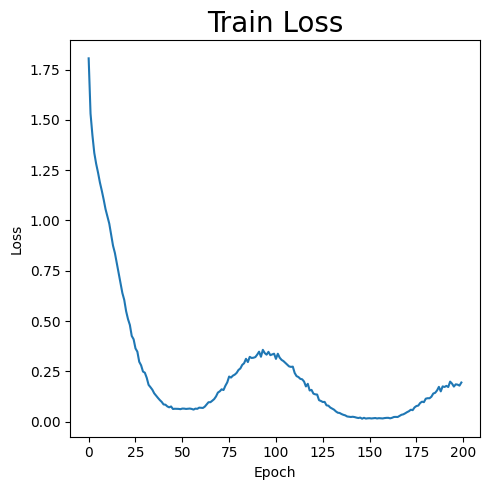

In [330]:
fig = plt.figure(figsize=(5,5))
ax1 = fig.add_subplot(1,1,1)
ax1.set_title("Train Loss", fontsize=20)
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
    # baseline = signal.medfilt(signal.medfilt(data, int(0.3 * 500) - 1) , int(0.7* 500) - 1)
ax1.plot(loss_list)
    # ax1.plot(baseline,"r")
    # ax1.plot(data-baseline,"g")
fig.tight_layout()
fig.savefig(f"/data/graduate/MI_Detection_Transformer/attention_result/Train_loss.png")

In [118]:
from sklearn.metrics import multilabel_confusion_matrix, hamming_loss, accuracy_score
label_names = ['NORM', 'MI', 'STTC', 'HYP', 'CD']
def extract_metrix(threshold, model, test_loader):
    model.eval()
    test_bar = tqdm(test_loader)
    total = len(test_loader.dataset)
    logits_list = []
    gt_list = []
    for step, (x,y) in enumerate(test_bar):
        x = x.to(device)
        y = y.to(device)
        with torch.no_grad():
            logits = model(x).cpu().detach().numpy()
    #             logits = logits.round()
            logits = logits > threshold
            logits = logits.astype(int)
            for l in logits:
                logits_list.append(l)
            y = y.cpu().detach().numpy()
            for gt in y:
    #                 print(gt.astype(int))
                gt_list.append(gt.astype(int))
    confusion = multilabel_confusion_matrix(gt_list,logits_list)
    print(f"==================== Threshold = {threshold} ====================")
    print(f"Exact Match Ratio, MR : : {accuracy_score(gt_list, logits_list)}")
    print(f"Hamming Loss : {hamming_loss(gt_list, logits_list)}")
    print(classification_report(gt_list, logits_list, target_names=label_names))
    print(confusion)
    MR = np.all(np.array(logits_list) == np.array(gt_list), axis=1).mean()

0.35 is Best Threshold

In [105]:
def Accuracy(conf):
    TN = conf[0][0]
    FP = conf[0][1]
    FN = conf[1][0]
    TP = conf[1][1]
    acc = (TP+TN)/(TP+FP+TN+FN)
    return acc

def Precision(conf):
    TN = conf[0][0]
    FP = conf[0][1]
    FN = conf[1][0]
    TP = conf[1][1]
    pre = (TP)/(TP+FP)
    return pre

def Recall(conf):
    TN = conf[0][0]
    FP = conf[0][1]
    FN = conf[1][0]
    TP = conf[1][1]
    recall = (TP)/(TP+FN)
    return recall

def f1Score(conf):
    TN = conf[0][0]
    FP = conf[0][1]
    FN = conf[1][0]
    TP = conf[1][1]
    pre = (TP)/(TP+FP)
    recall = (TP)/(TP+FN)
    f1score = (2*pre*recall)/(pre+recall)
    return f1score

In [106]:
from sklearn.metrics import multilabel_confusion_matrix, hamming_loss, accuracy_score
label_names = ['NORM', 'MI', 'STTC', 'CD', 'HYP']
def extract_pr_re(threshold, model, test_loader):
    test_bar = tqdm(test_loader)
    total = len(test_loader.dataset)
    pre = []
    rec = []
    acc = []
    f1s = []
    ham = []
    emr = []
    for th in threshold:
        logits_list = []
        gt_list = []
        print("Threshold :",th)
        model.eval()
        for step, (x,y) in enumerate(test_bar):
            x = x.to(device)
            y = y.to(device)
            with torch.no_grad():
                logits = model(x).cpu().detach().numpy()
        #             logits = logits.round()
                logits = logits > th
                logits = logits.astype(int)
                for l in logits:
                    logits_list.append(l)
                y = y.cpu().detach().numpy()
                for gt in y:
        #                 print(gt.astype(int))
                    gt_list.append(gt.astype(int))
        
        confu = multilabel_confusion_matrix(gt_list,logits_list)

        NORM = confu[0]
        MI = confu[1]
        STTC = confu[2]
        CD = confu[3]
        HYP = confu[4]
        
        ac = [Accuracy(NORM), Accuracy(MI), Accuracy(STTC), Accuracy(CD), Accuracy(HYP)]
        pr = [Precision(NORM), Precision(MI), Precision(STTC), Precision(CD), Precision(HYP)]
        re = [Recall(NORM), Recall(MI), Recall(STTC), Recall(CD), Recall(HYP)]
        f1 = [f1Score(NORM), f1Score(MI), f1Score(STTC), f1Score(CD), f1Score(HYP)]
        mr = accuracy_score(gt_list, logits_list)
        ha = hamming_loss(gt_list, logits_list)
        acc.append(ac)
        pre.append(pr)
        rec.append(re)
        f1s.append(f1)
        ham.append(ha)
        emr.append(mr)
    return pre,rec,acc,f1s,ham,emr

In [108]:
model_name = "Saved_ViT_model_FinalEpoch_16_0.0001_200_asy_bias.pth"
model_best = ViT().to(device)
test_loader = get_DataLoader(x_test, y_test, batch=32, num_workers=1, shuffle=True)
# model.load_state_dict(torch.load("Best_Saved_ViT_model_f192.pth"))
# model_best.load_state_dict(torch.load("models/Best_Saved_ViT_model_1121_400.13_16_210.pth")) #5e-5, 50, 8
model_best.load_state_dict(torch.load("models/1202/"+model_name))
# extract_metrix(0.7, best_models[-1][2], test_loader)
threshold = np.linspace(0,1,50)
# confu,clr = extract_pr_re(0.75, model_best, test_loader)
# class_map = {"NORM":0, "MI":1, "STTC":2, "CD":3, "HYP":4}

precisions, recalls, accuracys, f1Scores, hammings, emrs = extract_pr_re(threshold, model_best, test_loader)


  0%|                                                                           | 0/69 [00:00<?, ?it/s]

Threshold : 0.0


100%|██████████████████████████████████████████████████████████████████| 69/69 [00:02<00:00, 34.18it/s]

Threshold : 0.02040816326530612


Threshold : 0.04081632653061224
Threshold : 0.061224489795918366
Threshold : 0.08163265306122448
Threshold : 0.1020408163265306
Threshold : 0.12244897959183673
Threshold : 0.14285714285714285
Threshold : 0.16326530612244897
Threshold : 0.18367346938775508
Threshold : 0.2040816326530612
Threshold : 0.22448979591836732
Threshold : 0.24489795918367346
Threshold : 0.26530612244897955
Threshold : 0.2857142857142857
Threshold : 0.3061224489795918
Threshold : 0.32653061224489793
Threshold : 0.3469387755102041
Threshold : 0.36734693877551017
Threshold : 0.3877551020408163
Threshold : 0.4081632653061224
Threshold : 0.42857142857142855
Threshold : 0.44897959183673464
Threshold : 0.4693877551020408
Threshold : 0.4897959183673469
Threshold : 0.5102040816326531
Threshold : 0.5306122448979591
Threshold : 0.5510204081632653
Threshold : 0.5714285714285714
Threshold : 0.5918367346938775
Threshold : 0.6122448979591836
Threshold : 0.6326530612244897
Threshold : 0.6530612244897959
Threshold : 0.6734693877

/tmp/ipykernel_1943576/1688271352.py:14: RuntimeWarning: invalid value encountered in scalar divide
  pre = (TP)/(TP+FP)
/tmp/ipykernel_1943576/1688271352.py:30: RuntimeWarning: invalid value encountered in scalar divide
  pre = (TP)/(TP+FP)


In [109]:
for i, th in enumerate(threshold):
    if th >= 0.5 and th <= 0.8:
        print(i, end=" ")

25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 

In [110]:
np_pre = np.array(precisions)
np_rec = np.array(recalls)
np_accuracy = np.array(accuracys)
np_f1 = np.array(f1Scores)
np_ham = np.array(hammings)
np_emr = np.array(emrs)

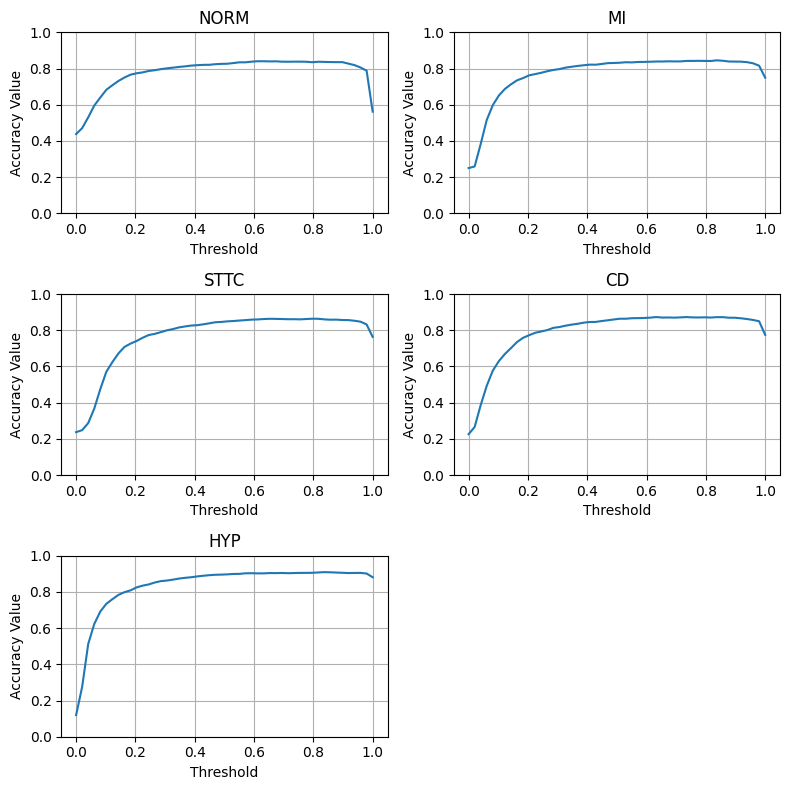

In [114]:
fig = plt.figure(figsize=(8,8))
for i in range(5):
    ax1 = fig.add_subplot(3,2,i+1)
    ax1.set_title(label_names[i])
    ax1.set_xlabel("Threshold")
    ax1.set_ylabel("Accuracy Value")
    ax1.set_ylim(0,1)
    ax1.plot(threshold,np_accuracy[:,i],label="Accuracy")
    ax1.grid()
fig.tight_layout()
fig.savefig(f"/data/graduate/MI_Detection_Transformer/attention_result/Accuracy.png")

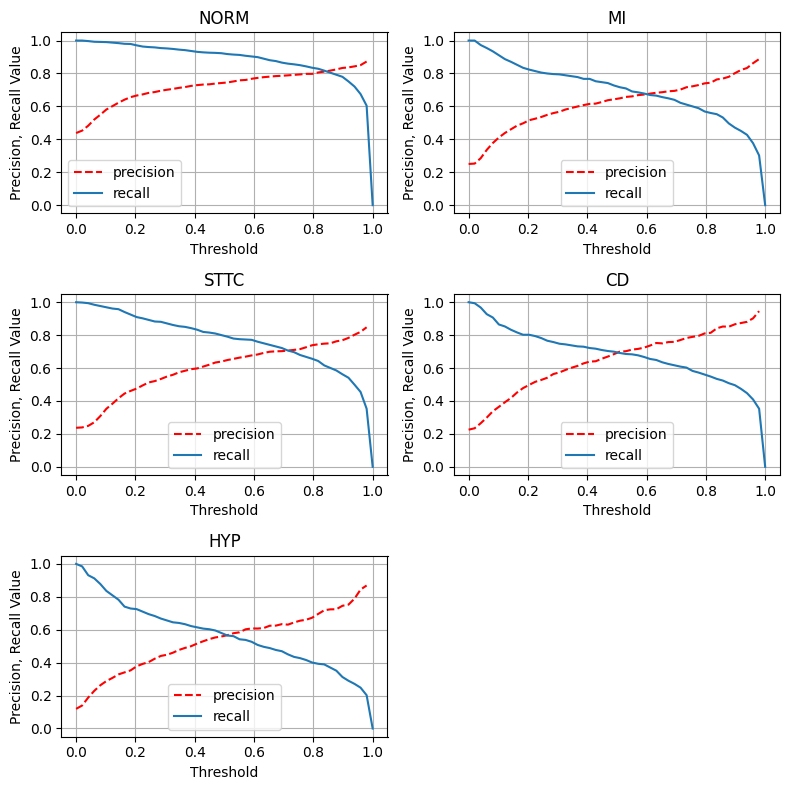

In [113]:
fig = plt.figure(figsize=(8,8))
for i in range(5):
    ax1 = fig.add_subplot(3,2,i+1)
    ax1.set_title(label_names[i])
    ax1.set_xlabel("Threshold")
    ax1.set_ylabel("Precision, Recall Value")
    ax1.plot(threshold,np_pre[:,i],"r--",label="precision")
    ax1.plot(threshold,np_rec[:,i],label="recall")
    ax1.legend()
    ax1.grid()
fig.tight_layout()
fig.savefig(f"/data/graduate/MI_Detection_Transformer/attention_result/pre_rec.png")

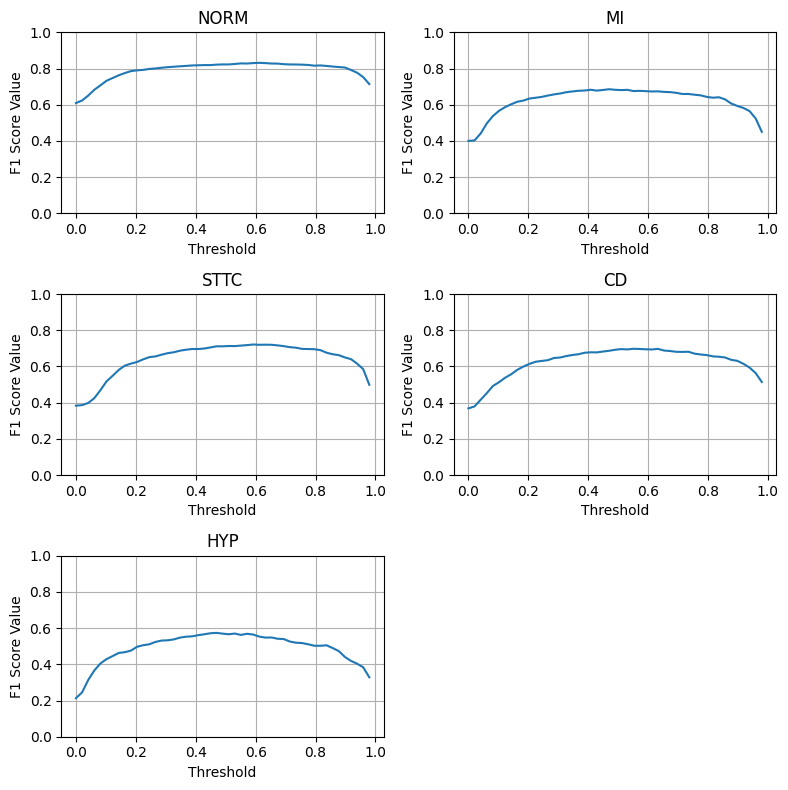

In [115]:
fig = plt.figure(figsize=(8,8))
for i in range(5):
    ax1 = fig.add_subplot(3,2,i+1)
    ax1.set_title(label_names[i])
    ax1.set_xlabel("Threshold")
    ax1.set_ylabel("F1 Score Value")
    ax1.set_ylim(0,1)
    ax1.plot(threshold,np_f1[:,i],label="F1 Score")
    ax1.grid()

fig.tight_layout()
fig.savefig(f"/data/graduate/MI_Detection_Transformer/attention_result/f1scores.png")

In [499]:
acc_df = pd.DataFrame(np.round(np_accuracy[25:40,:],3),columns=[["Accuracy"]*5,label_names])
pre_df = pd.DataFrame(np.round(np_pre[25:40,:],3),columns=[["Precision"]*5,label_names])
rec_df = pd.DataFrame(np.round(np_rec[25:40,:],3),columns=[["Recall"]*5,label_names])
f1_df = pd.DataFrame(np.round(np_f1[25:40,:],3),columns=[["F1 Score"]*5,label_names])
ham_df = pd.DataFrame(np.round(np_ham[25:40],5),columns=[["Hamming Loss"],["Mean"]])
emr_df = pd.DataFrame(np.round(np_emr[25:40],5),columns=[["Exact Match Ratio"],["Mean"]])
all_df = pd.concat([acc_df,pre_df,rec_df,f1_df,ham_df,emr_df], axis=1)
# np.round(threshold[25:40],3)
all_df = all_df.set_index(np.round(threshold[25:40],2))
all_df.to_csv(f"/data/graduate/MI_Detection_Transformer/Result_CSV.csv")

In [123]:
model_name = "Saved_ViT_model_FinalEpoch_16_0.0001_200_asy_bias.pth"
model_best = ViT().to(device)
# model.load_state_dict(torch.load("Best_Saved_ViT_model_f192.pth"))
# model_best.load_state_dict(torch.load("models/Best_Saved_ViT_model_1121_400.13_16_210.pth")) #5e-5, 50, 8
model_best.load_state_dict(torch.load("models/1202/"+model_name))
# extract_metrix(0.7, best_models[-1][2], test_loader)
extract_metrix(0.73, model_best, test_loader)
# extract_metrix(0.75, model, test_loader)

100%|██████████████████████████████████████████████████████████████████| 69/69 [00:02<00:00, 34.33it/s]

==================== Threshold = 0.73 ====================
Exact Match Ratio, MR : : 0.5777979981801638
Hamming Loss : 0.1370336669699727
              precision    recall  f1-score   support

        NORM       0.79      0.86      0.82       963
          MI       0.71      0.61      0.66       550
        STTC       0.71      0.70      0.70       521
         HYP       0.78      0.60      0.68       496
          CD       0.64      0.44      0.52       262

   micro avg       0.75      0.69      0.72      2792
   macro avg       0.73      0.64      0.68      2792
weighted avg       0.74      0.69      0.71      2792
 samples avg       0.72      0.71      0.70      2792

[[[1017  218]
  [ 139  824]]

 [[1511  137]
  [ 212  338]]

 [[1528  149]
  [ 158  363]]

 [[1617   85]
  [ 196  300]]

 [[1872   64]
  [ 148  114]]]



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


torch.Size([1, 251, 768]) torch.Size([1, 6, 251, 251])
[1. 0. 0. 0. 0.]


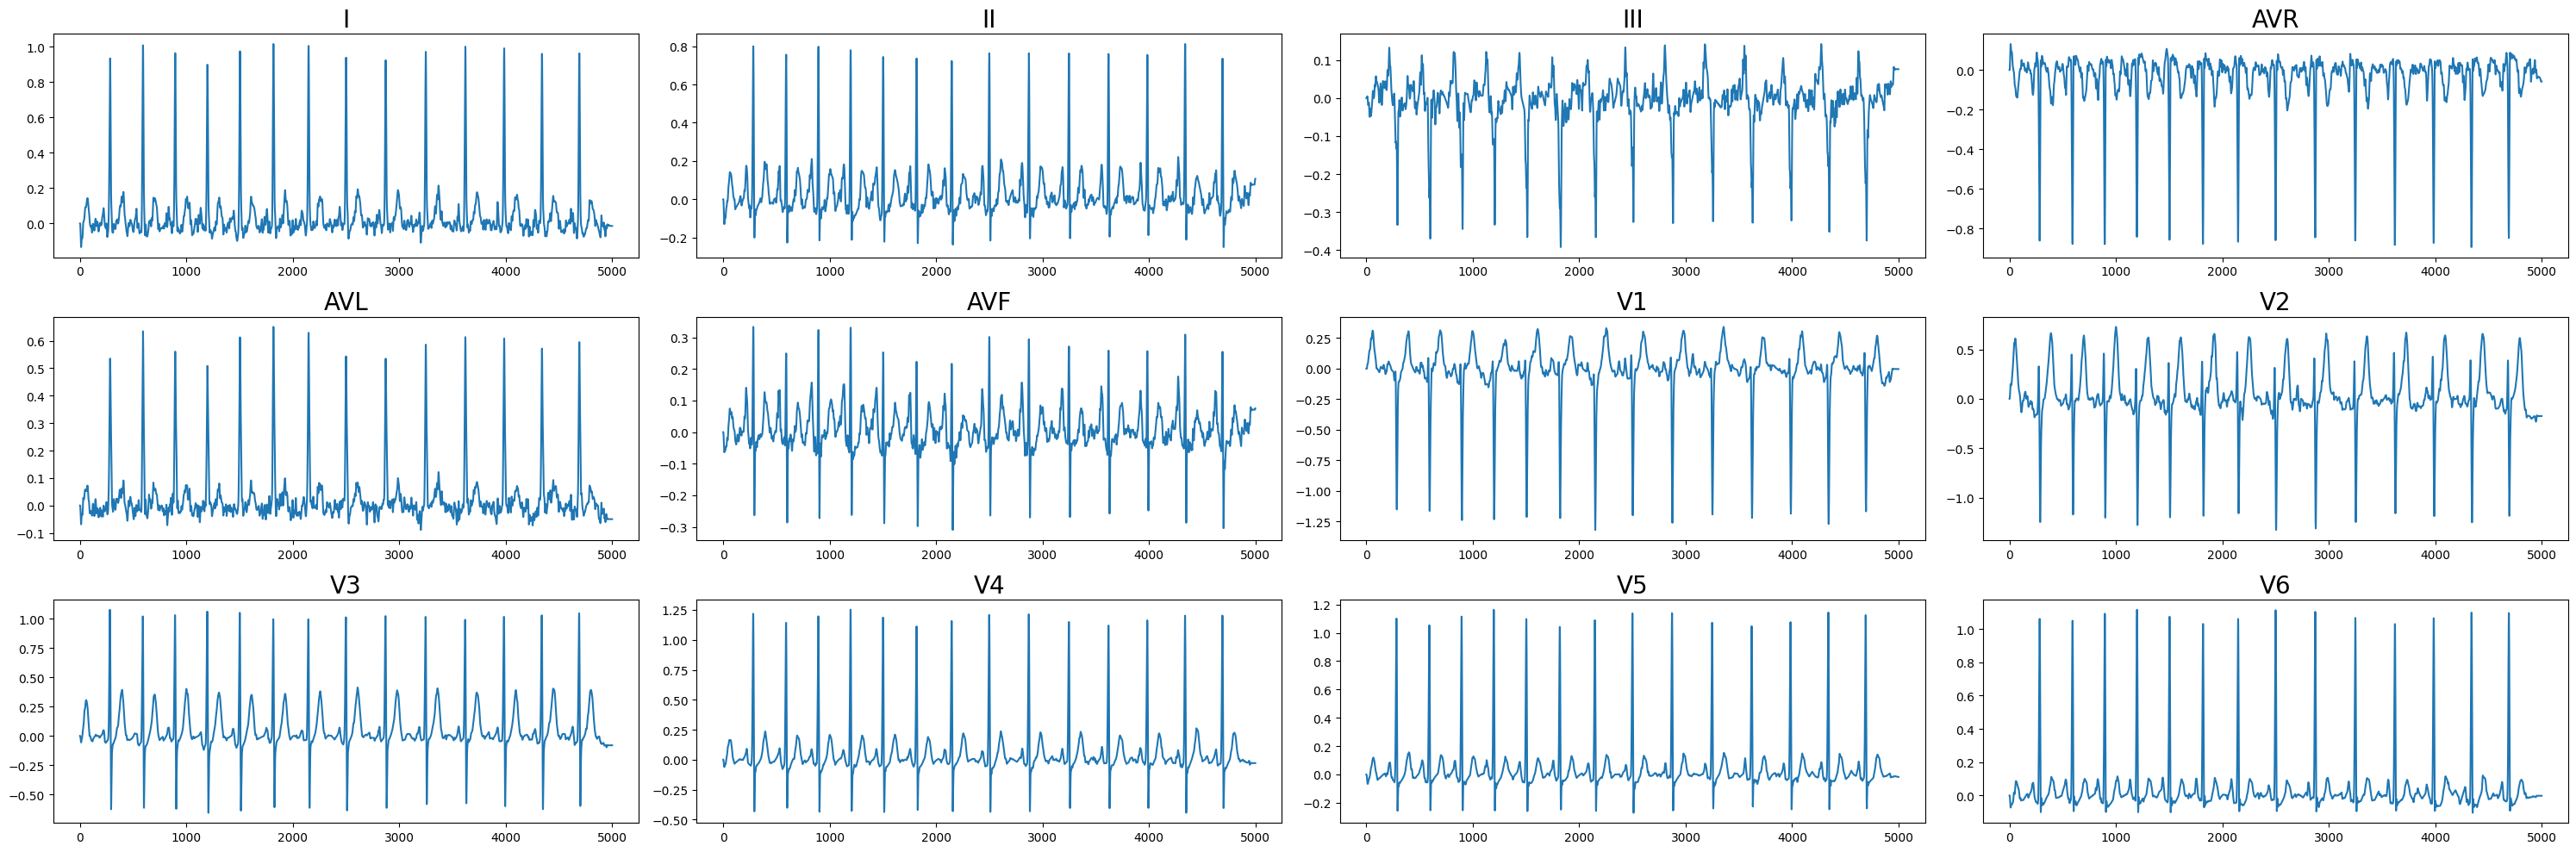

In [121]:
sel = 15
test_signal = torch.Tensor(x_test[sel])
test_signal = test_signal.unsqueeze(0)
attns = model_best.get_last_selfattention(test_signal.cuda())
attn = attns[0,:,0,1:]
attn = torch.transpose(attn, 1, 0)
attn = torch.unsqueeze(torch.unsqueeze(attn, 0), 0)
attn = Func.interpolate(attn, size=(5000, 6), mode='bicubic')[0, 0]
attn = attn.detach().cpu().numpy()
p_signal = test_signal[0].transpose(1,0).detach().numpy()
fig = plt.figure(figsize=(30,10))
leadNames = ['I', 'II', 'III', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
print(y_test[sel])
for i,lead in enumerate(leadNames):
    ax1 = fig.add_subplot(3,4,i+1)
    ax1.set_title(leadNames[i], fontsize=20)
    ax1.plot(p_signal[:,i])
fig.tight_layout()
# class_map = {"NORM":0, "MI":1, "STTC":2, "CD":3, "HYP":4}

In [54]:
def plot_ax(ax, signal, sampling_rate, plot_grid=True):
    color_line = (0, 0, 0.7)
    color_major = (1, 0, 0)
    color_minor = (1, 0.7, 0.7)

    ax.plot(np.arange(0, len(signal)), signal, linewidth=0.5, color=color_line)

    if plot_grid:
        # set major grid
        xmajor = np.arange(0, len(signal), sampling_rate * 0.2)
        ymajor = np.arange(signal.min(), signal.max(), 0.5)
        ax.set_xticks(xmajor, minor=False)
        ax.set_xticks(xmajor, minor=False)
        ax.set_yticks(ymajor, minor=False)
        ax.grid(which="major", color=color_major, linewidth=0.5)

        # set minor grid
        xminor = np.arange(0, len(signal), sampling_rate * 0.04)
        yminor = np.arange(signal.min(), signal.max(), 0.1)
        ax.set_xticks(xminor, minor=True)
        ax.set_yticks(yminor, minor=True)
        ax.grid(which="minor", color=color_minor, linewidth=0.5)

    ax.axes.xaxis.set_ticklabels([])
    ax.axes.yaxis.set_ticklabels([])

    ax.margins(0)

    ax.set_ylim(signal.min(), signal.max())
    
def plot_12(ecg, sampling_rate, plot_grid=True):
    "This function is ridiculously slow and there are mutch better ways to implemt"
    figsize = (25, 1.5 * 10)

    height_ratios = [ecg[:, i].max() - ecg[:, i].min() for i in range(12)]
    height_ratios = [i / height_ratios[0] for i in height_ratios]
    fig, axs = plt.subplots(12, 1, figsize=figsize, gridspec_kw={"height_ratios": height_ratios})
    fig.subplots_adjust(hspace=0.0)
    for i, ax in enumerate(axs):
        plot_ax(ax, ecg[:, i], sampling_rate, plot_grid=plot_grid)
        ax.pcolorfast(ax.get_xlim(), ax.get_ylim(), attn[:, head][np.newaxis], cmap="Reds", alpha=0.6)
        ax.set_ylabel(lead_index[i], fontsize=13)
        
    return fig, axs

#python plot_attention.py sadd/JS05865 vit_best/ 6
lead_index = ["I", "II", "III", "aVR", "aVL", "aVF", "V1", "V2", "V3", "V4", "V5", "V6"]
# lead = 3
for head in range(6):
    # for lead in range(12):
        # fig, ax = plt.subplots(figsize=(10, 1.5))
        # plot_ax(ax, signal=p_signal[:,lead], plot_grid=False, sampling_rate=500)
        # ax.pcolorfast(ax.get_xlim(), ax.get_ylim(), attn[:, head][np.newaxis], cmap="Reds", alpha=0.6)
    fig, axs = plot_12(p_signal,500)
    # fig.savefig(f"/data/graduate/MI_Detection_Transformer/attention_result/head_{head}_1201.png")
        # ax.set_ylabel(lead_index[lead], fontsize=13)

NameError: name 'p_signal' is not defined